In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime
import holidays
import math

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [8]:
dataset = dataset.iloc[: , 1:]

In [9]:
dataset.head(4)

,SegmentId,hour,day,year,Speed,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Friday,holiday,Lufttemperatur,Nederbördsmängd,Vindhastighet,Snödjup,Temperature-with-last-known-value-on-nan,Wind-speed-avg-when-nan
0,226255131,0,155,2019,91.383333,0,0,0,0,1,0,0,0,13.7,0.0,4.7,0.0,13.7,4.7
1,226255131,1,155,2019,92.000000,0,0,0,0,1,0,0,0,14.1,0.0,5.0,0.0,14.1,5.0
2,226255131,2,155,2019,93.666667,0,0,0,0,1,0,0,0,14.2,0.0,4.8,0.0,14.2,4.8
3,226255131,3,155,2019,86.216667,0,0,0,0,1,0,0,0,14.3,0.0,4.9,0.0,14.3,4.9


In [13]:
values = dataset.values
# ensure all data is float
values = values.astype('float32')

In [29]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(1, 18))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,1.000000,8.172602,1.0,12.246119,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.577778,1.0,5.035353,1.0,11.577778,5.035353,6.838384
1,1.0,1.739130,8.172602,1.0,12.328160,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.766666,1.0,5.292929,1.0,11.766666,5.292929,5.979798
2,1.0,2.478261,8.172602,1.0,12.549889,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.813889,1.0,5.121212,1.0,11.813889,5.121212,6.580808
3,1.0,3.217391,8.172602,1.0,11.558759,1.0,1.0,1.0,1.0,18.0,1.0,1.0,1.0,11.861111,1.0,5.207071,1.0,11.861111,5.207071,5.636364


In [15]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [31]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,18)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)','var5(t-1)', 'var6(t-1)', 'var7(t-1)','var8(t-1)','var9(t-1)','var10(t-1)','var11(t-1)','var12(t-1)','var13(t-1)','var14(t-1)','var15(t-1)','var16(t-1)','var17(t-1)','var18(t-1)','var19(t-1)','var20(t-1)','var1(t)',]
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
id                                                                     
1         1.0   1.000000   8.172602        1.0  12.246119        1.0   
2         1.0   1.739130   8.172602        1.0  12.328160        1.0   
3         1.0   2.478261   8.172602        1.0  12.549889        1.0   
4         1.0   3.217391   8.172602        1.0  11.558759        1.0   

    var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var12(t-1)  var13(t-1)  \
id                                               ...                           
1         1.0        1.0        1.0        18.0  ...         1.0         1.0   
2         1.0        1.0        1.0        18.0  ...         1.0         1.0   
3         1.0        1.0        1.0        18.0  ...         1.0         1.0   
4         1.0        1.0        1.0        18.0  ...         1.0         1.0   

    var14(t-1)  var15(t-1)  var16(t-1)  var17(t-1)  var18(t-1)  var19(t-1)  \
id      

In [32]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.75)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [33]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(16164, 1, 20) (16164,) (5377, 1, 20) (5377,)


In [43]:
model_gru = Sequential()
model_gru.add(GRU(512, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_gru.add(GRU(units=80, return_sequences=True))
model_gru.add(GRU(units=80))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam')
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 1, 512)            820224    
_________________________________________________________________
gru_7 (GRU)                  (None, 1, 80)             142560    
_________________________________________________________________
gru_8 (GRU)                  (None, 80)                38880     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 81        
Total params: 1,001,745
Trainable params: 1,001,745
Non-trainable params: 0
_________________________________________________________________


In [35]:
# fit network
gru_history = model_gru.fit(train_X, train_y, epochs=120,validation_data=(test_X, test_y), batch_size=50, shuffle=False)

Epoch 1/120
253/253 [==============================] - 7s 10ms/step - loss: 2.1878 - val_loss: 1.0077
Epoch 2/120
253/253 [==============================] - 2s 6ms/step - loss: 1.0526 - val_loss: 0.8928
Epoch 3/120
253/253 [==============================] - 2s 6ms/step - loss: 1.0342 - val_loss: 0.7861
Epoch 4/120
253/253 [==============================] - 2s 7ms/step - loss: 0.9403 - val_loss: 0.8179
Epoch 5/120
253/253 [==============================] - 2s 7ms/step - loss: 0.8763 - val_loss: 0.8221
Epoch 6/120
253/253 [==============================] - 2s 7ms/step - loss: 0.8739 - val_loss: 0.7999
Epoch 7/120
253/253 [==============================] - 2s 7ms/step - loss: 0.9069 - val_loss: 0.8149
Epoch 8/120
253/253 [==============================] - 2s 7ms/step - loss: 0.8719 - val_loss: 0.8126
Epoch 9/120
253/253 [==============================] - 2s 7ms/step - loss: 0.8430 - val_loss: 0.8085
Epoch 10/120
253/253 [==============================] - 2s 7ms/step - loss: 0.8325 - val_l

253/253 [==============================] - 2s 9ms/step - loss: 0.6273 - val_loss: 0.8257
Epoch 82/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6280 - val_loss: 0.8148
Epoch 83/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6244 - val_loss: 0.8522
Epoch 84/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6241 - val_loss: 0.8205
Epoch 85/120
253/253 [==============================] - 2s 7ms/step - loss: 0.6236 - val_loss: 0.8243
Epoch 86/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6202 - val_loss: 0.8275
Epoch 87/120
253/253 [==============================] - 2s 7ms/step - loss: 0.6226 - val_loss: 0.8261
Epoch 88/120
253/253 [==============================] - 2s 7ms/step - loss: 0.6202 - val_loss: 0.8166
Epoch 89/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6198 - val_loss: 0.8359
Epoch 90/120
253/253 [==============================] - 2s 8ms/step - loss: 0.6226 - val_loss: 

In [36]:
pred_y =  model_gru.predict(test_X)

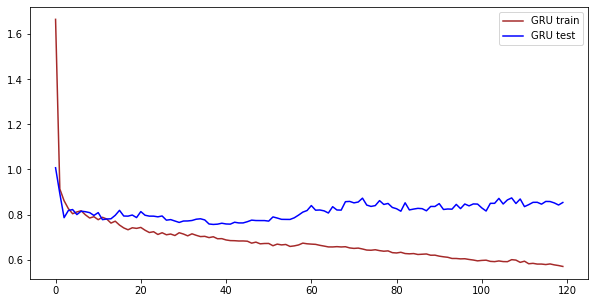

In [37]:
pyplot.plot(gru_history.history['loss'], label='GRU train', color='brown')
pyplot.plot(gru_history.history['val_loss'], label='GRU test', color='blue')
pyplot.legend()
pyplot.show()

In [38]:
test_y.reshape(5377,1)

array([[4.6060605],
       [5.3787875],
       [4.00505  ],
       ...,
       [7.782828 ],
       [7.353535 ],
       [7.6969705]], dtype=float32)

In [39]:
pred_y

array([[4.019364 ],
       [4.4274483],
       [5.110063 ],
       ...,
       [6.4897213],
       [8.358364 ],
       [8.159375 ]], dtype=float32)

1.2813367
0.7937019359354576
1.131961423880471
0.8535182


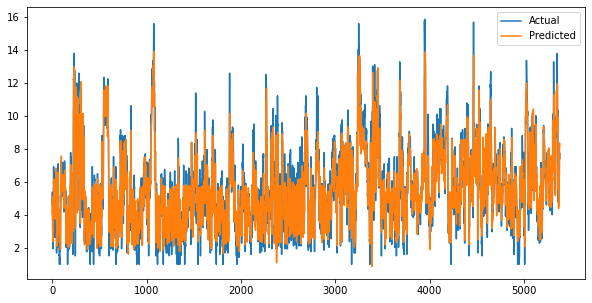

In [40]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

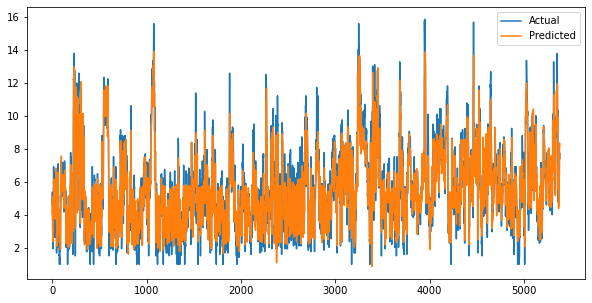

In [41]:
#visualization over full data
tra = test_X
tes = test_y
fp = model_gru.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

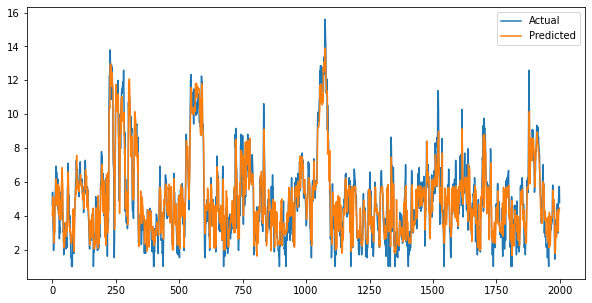

In [42]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()